Necessary Libraries for Text and Image

In [ ]:
!pip install wordcloud

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 12.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import emoji
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


News Event Detection Annotated Dataset
Link : https://github.com/RetrainIt/NED

In [ ]:
file_path = '/content/drive/MyDrive/NED.xlsx'
data = pd.read_excel(file_path)

In [ ]:
data.head(5)

,Event_id,Event_name,Image_link,Text,Time
0,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AdpyAwhCEAEA4Vt.jpg,Just next to Hua Mak Airport Link station..Sri...,2011-11-07 14:01:00
1,E1,2011 Thailand Floods,https://pbs.twimg.com/media/Adfv5OaCEAAReA5.jpg,ATM flood protection at Rajaprasong,2011-11-05 15:15:00
2,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AdddZBVCIAAPmwh.jpg,“@RichardBarrow: 11:34 Tesco Lotus Lat Phrao i...,2011-11-05 04:36:00
3,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AeI-0rfCMAAFPe-.jpg,Don Mueang residents removing big bags at 2.30...,2011-11-13 15:25:00
4,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AdUXtPJCMAEJKX6.jpg,Eww! RT @RichardBarrow: Water goes down in Ayu...,2011-11-03 10:19:00


In [ ]:
data.tail(5)

,Event_id,Event_name,Image_link,Text,Time
17361,E40,2021 Haiti earthquake,https://pbs.twimg.com/media/E8xsBioUYAAYKOe.jpg,"Oh, @CNN. “Hundereds” 😬 #spellingcounts earthq...",2021-08-14 19:56:00
17362,E40,2021 Haiti earthquake,https://pbs.twimg.com/media/E8w_DnPWQAIkjfq.jpg,Haiti needs more than prayers😭⚰ SOS earthquake,2021-08-14 16:40:00
17363,E40,2021 Haiti earthquake,https://pbs.twimg.com/media/E8x1jjrWEAk40P7.jpg,"⚠️🇭🇹: A mild of magnitude M4.0, was registered...",2021-08-14 20:45:00
17364,E40,2021 Haiti earthquake,https://pbs.twimg.com/media/E8x4t9-X0Ao45H1.jpg,"RT CRSnews ""The death toll continues to climb ...",2021-08-14 21:20:00
17365,E40,2021 Haiti earthquake,https://pbs.twimg.com/media/E8xXD6nXoAEo9Du.jp...,We’re devastated to share that a 7.2 hit this ...,2021-08-14 18:25:00


Data Visualization

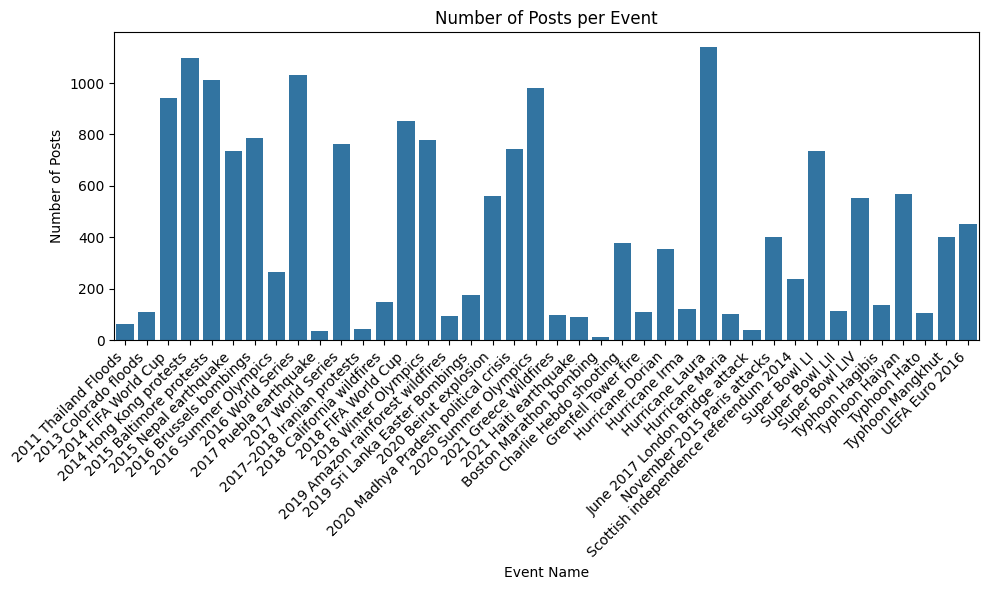

In [ ]:
event_counts = data.groupby('Event_name').size().reset_index(name='Counts')

plt.figure(figsize=(10, 6))
sns.barplot(x='Event_name', y='Counts', data=event_counts)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Posts per Event')
plt.ylabel('Number of Posts')
plt.xlabel('Event Name')
plt.tight_layout()
plt.show()

<ipython-input-11-2c5cb11919b8>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  timeline_data_yearly = data.groupby([pd.Grouper(key='Time', freq='Y'), 'Event_name']).size().reset_index(name='Counts')


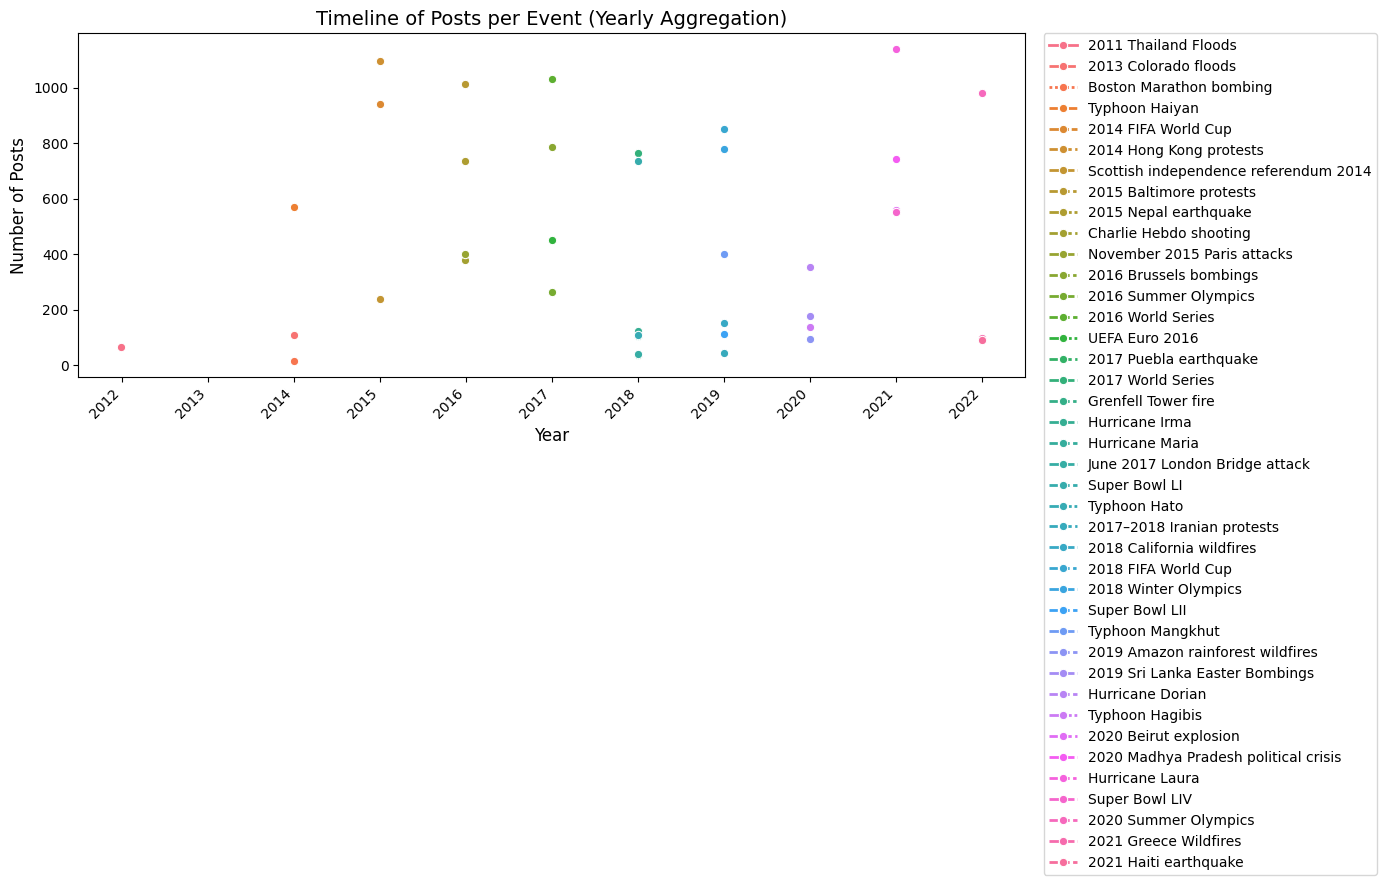

In [ ]:
timeline_data_yearly = data.groupby([pd.Grouper(key='Time', freq='Y'), 'Event_name']).size().reset_index(name='Counts')

plt.figure(figsize=(14, 7))
sns.lineplot(x='Time', y='Counts', hue='Event_name', data=timeline_data_yearly, marker='o', style='Event_name', linewidth=2)

plt.title('Timeline of Posts per Event (Yearly Aggregation)', fontsize=14)
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45, ha='right')

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()

plt.show()

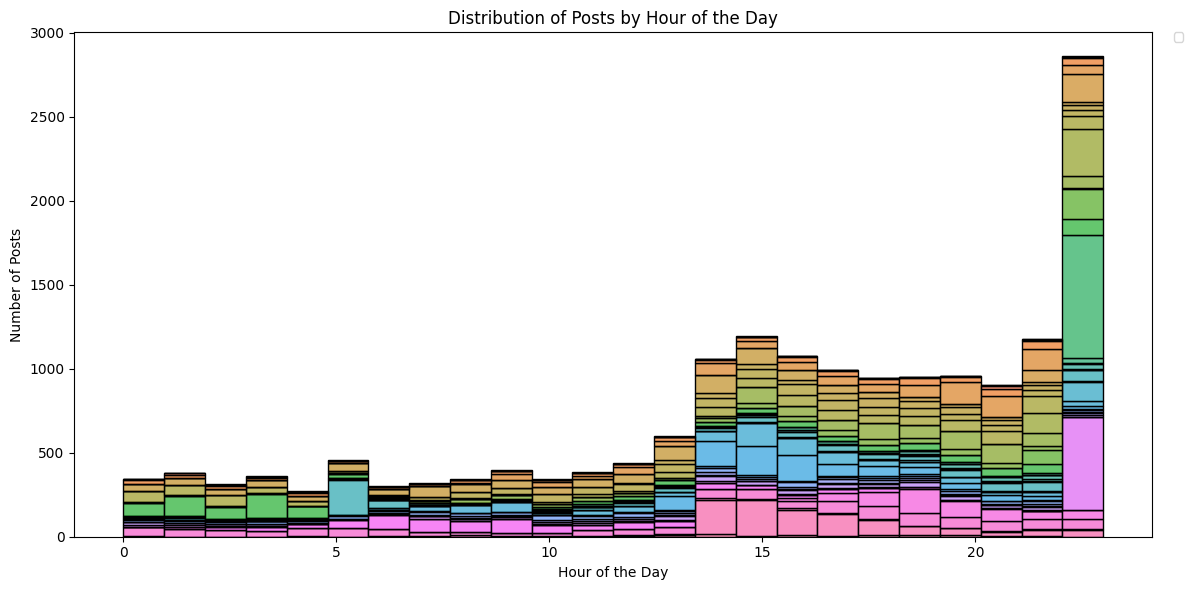

In [ ]:
data['hour'] = data['Time'].dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='hour', hue='Event_name', multiple='stack', bins=24)
plt.title('Distribution of Posts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Posts')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize='small')
plt.tight_layout()
plt.show()

Image Preprocessing Pipeline

In [ ]:
def download_images_by_event(image_urls, event_names, base_folder='/content/drive/MyDrive/downloaded_images'):
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)

    for i, (url, event_name) in enumerate(zip(image_urls, event_names)):
        event_folder = os.path.join(base_folder, event_name)
        if not os.path.exists(event_folder):
            os.makedirs(event_folder)
        image_filename = f'image_{i}.jpg'
        image_path = os.path.join(event_folder, image_filename)

        try:
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(image_path, 'wb') as file:
                    file.write(response.content)
                print(f"Successfully downloaded image {i} from {url}")
            else:
                print(f"Failed to download image {i} from {url}")
        except Exception as e:
            print(f"Error downloading image {i} from {url}: {e}")

image_links = data['Image_link'].tolist()
event_names = data['Event_name'].tolist()
download_images_by_event(image_links, event_names)

In [ ]:
import os

def get_image_filename(index):
    return f'image_{index}.jpg'

def remove_rows_with_missing_images(data, image_folder='downloaded_images'):
    valid_rows = []
    found_count = 0
    missing_count = 0

    for i, row in data.iterrows():
        event_name = row['Event_name']
        image_filename = get_image_filename(i)
        image_path = os.path.join(image_folder, event_name, image_filename)

        if os.path.exists(image_path):
            row['Image_Filename'] = image_filename  # Add the image filename as a column
            valid_rows.append(row)
            found_count += 1
        else:
            missing_count += 1

    filtered_data = pd.DataFrame(valid_rows).reset_index(drop=True)

    print(f"Total images checked: {len(data)}")
    print(f"Images found: {found_count}")
    print(f"Images missing: {missing_count}")

    return filtered_data

image_folder = '/content/drive/MyDrive/downloaded_images'
filtered_data = remove_rows_with_missing_images(data, image_folder=image_folder)
print(f"Filtered data length: {len(filtered_data)}")


Total images checked: 17366
Images found: 12793
Images missing: 4573
Filtered data length: 12793


In [ ]:
filtered_data.head()

,Event_id,Event_name,Image_link,Text,Time,Image_Filename
0,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AdpyAwhCEAEA4Vt.jpg,Just next to Hua Mak Airport Link station..Sri...,2011-11-07 14:01:00,image_0.jpg
1,E1,2011 Thailand Floods,https://pbs.twimg.com/media/Adfv5OaCEAAReA5.jpg,ATM flood protection at Rajaprasong,2011-11-05 15:15:00,image_1.jpg
2,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AdddZBVCIAAPmwh.jpg,“@RichardBarrow: 11:34 Tesco Lotus Lat Phrao i...,2011-11-05 04:36:00,image_2.jpg
3,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AeI-0rfCMAAFPe-.jpg,Don Mueang residents removing big bags at 2.30...,2011-11-13 15:25:00,image_3.jpg
4,E1,2011 Thailand Floods,https://pbs.twimg.com/media/AdUXtPJCMAEJKX6.jpg,Eww! RT @RichardBarrow: Water goes down in Ayu...,2011-11-03 10:19:00,image_4.jpg


In [ ]:
event_counts = filtered_data['Event_name'].value_counts()
print("Number of rows under each event after filtering:")
print(event_counts)

Number of rows under each event after filtering:
Event_name
2016 World Series                        935
2014 FIFA World Cup                      875
2015 Baltimore protests                  862
2014 Hong Kong protests                  860
2018 FIFA World Cup                      730
2016 Brussels bombings                   710
2017 World Series                        683
Super Bowl LI                            666
2018 Winter Olympics                     657
2020 Madhya Pradesh political crisis     656
2015 Nepal earthquake                    575
Typhoon Haiyan                           550
Super Bowl LIV                           477
UEFA Euro 2016                           411
November 2015 Paris attacks              364
Charlie Hebdo shooting                   308
Typhoon Mangkhut                         301
Hurricane Dorian                         289
2020 Beirut explosion                    277
2016 Summer Olympics                     239
Scottish independence referendum 2014   

In [ ]:
top_10_classes = filtered_data['Event_name'].value_counts().index[:5]
filtered_data_top_10 = filtered_data[filtered_data['Event_name'].isin(top_10_classes)]

print(f"Filtered data length for top 10 classes: {len(filtered_data_top_10)}")
event_counts_top_10 = filtered_data_top_10['Event_name'].value_counts()
print("Number of rows under each of the top 10 events after filtering:")
print(event_counts_top_10)

Filtered data length for top 10 classes: 4262
Number of rows under each of the top 10 events after filtering:
Event_name
2016 World Series          935
2014 FIFA World Cup        875
2015 Baltimore protests    862
2014 Hong Kong protests    860
2018 FIFA World Cup        730
Name: count, dtype: int64


NLP Preprocessing Pipeline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")
stop_words = set(stopwords.words('english'))
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = remove_emojis(text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

filtered_data_top_10['cleaned_text'] = filtered_data_top_10['Text'].apply(clean_text)

<ipython-input-10-93fd1ca4bc3f>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_top_10['cleaned_text'] = filtered_data_top_10['Text'].apply(clean_text)


In [ ]:
filtered_data_top_5[['cleaned_text']].tail(5)

,cleaned_text
5228,smallest nation reach final since uruguay croa...
5229,english pretty boys terrible defending bel eng...
5230,playoffs finals worldcup belgiumvsengland spor...
5231,glo rewards customers russian trip thecable bi...
5232,one game go beleng


In [ ]:
filtered_data_top_10.head()

,Event_id,Event_name,Image_link,Text,Time,Image_Filename,cleaned_text,encoded_labels
0,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsVQY7iCYAADOcm.png,World Cup #Brazil 2014 10 Most Memorable World...,2014-07-12 09:01:00,image_1615.jpg,world cup brazil memorable world cup final mom...,0
1,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsX0i5eCEAAvAlw.jpg,“@PIA_INCA: Lol...Neymar right now .... #BRAvs...,2014-07-12 21:01:00,image_1096.jpg,piainca lolneymar right bravsned biguimaraes,0
2,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsUxGwqIgAAKLHT.jpg,💙 “@SuperSportTV: Neymar wants Messi to win th...,2014-07-12 17:36:00,image_1164.jpg,supersporttv neymar wants messi win arg bitlyn...,0
3,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsYBgkdIEAEEDIZ.jpg,"""@AFP: #Ned beat #Bra 3-0 in play-off. Photo b...",2014-07-12 21:59:00,image_1608.jpg,afp ned beat bra playoff photo damienmeyerafp,0
4,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsXpGHcCAAEiwBp.jpg,Thank goodness for TV’s on the plane! #HawaiiB...,2014-07-12 20:09:00,image_1207.jpg,thank goodness tvs plane hawaiibound vacationw...,0


In [ ]:
def generate_wordcloud(event_name):
    event_text = ' '.join(filtered_data[filtered_data['Event_name'] == event_name]['cleaned_text'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(event_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {event_name}')
    plt.show()

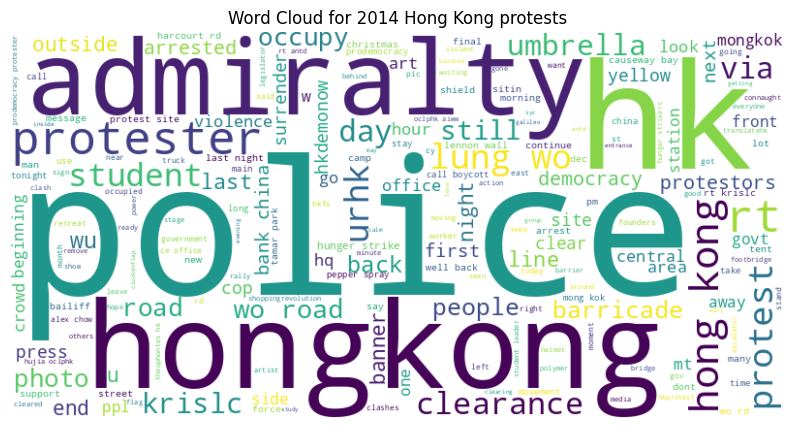

In [ ]:
generate_wordcloud('2014 Hong Kong protests')

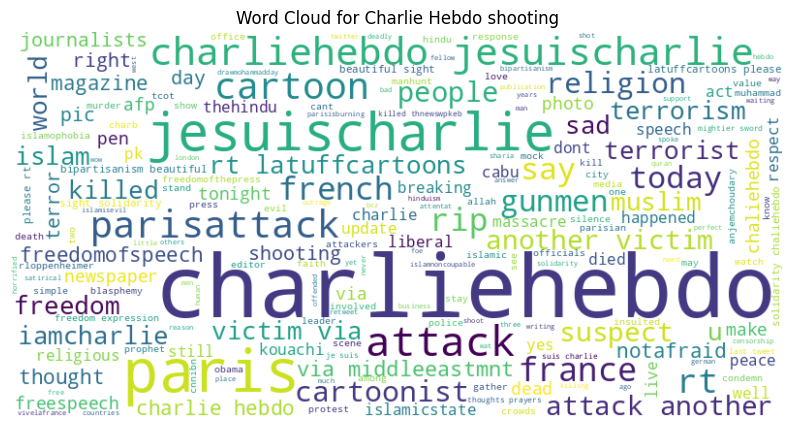

In [ ]:
generate_wordcloud('Charlie Hebdo shooting')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
filtered_data_top_10['encoded_labels'] = label_encoder.fit_transform(filtered_data_top_10['Event_name'])

<ipython-input-11-ffe30fc0d117>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_top_10['encoded_labels'] = label_encoder.fit_transform(filtered_data_top_10['Event_name'])


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def reduce_data_per_event(data, fraction=0.5):
    reduced_data = pd.DataFrame()
    stats = []

    for event_name in filtered_data_top_10['Event_name'].unique():
        event_data = filtered_data_top_10[filtered_data_top_10['Event_name'] == event_name]
        original_count = len(event_data)
        reduced_event_data = event_data.sample(frac=fraction, random_state=42).reset_index(drop=True)
        reduced_count = len(reduced_event_data)

        stats.append({
            'Event Name': event_name,
            'Original Count': original_count,
            'Reduced Count': reduced_count
        })

        reduced_data = pd.concat([reduced_data, reduced_event_data])

    for stat in stats:
        print(f"Event: {stat['Event Name']} | Original Count: {stat['Original Count']} | Reduced Count: {stat['Reduced Count']}")

    return reduced_data.reset_index(drop=True)

filtered_data = reduce_data_per_event(filtered_data_top_10, fraction=0.75)

print("Data reduction complete.")


Event: 2014 FIFA World Cup | Original Count: 875 | Reduced Count: 656
Event: 2014 Hong Kong protests | Original Count: 860 | Reduced Count: 645
Event: 2015 Baltimore protests | Original Count: 862 | Reduced Count: 646
Event: 2016 World Series | Original Count: 935 | Reduced Count: 701
Event: 2018 FIFA World Cup | Original Count: 730 | Reduced Count: 548
Data reduction complete.


In [ ]:
len(filtered_data_top_10)

4262

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

def stratified_split(filtered_data, train_size=0.8, test_size=0.2, random_state=42):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for event_name in filtered_data_top_10['Event_name'].unique():
        event_data = filtered_data_top_10[filtered_data['Event_name'] == event_name]

        if len(event_data) > 1:
            train_event, test_event = train_test_split(
                event_data, train_size=train_size, random_state=random_state, stratify=event_data['Event_name']
            )

            train_data = pd.concat([train_data, train_event])
            test_data = pd.concat([test_data, test_event])
        else:
            train_data = pd.concat([train_data, event_data])

    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_data, test_data = stratified_split(filtered_data_top_10, train_size=0.8, test_size=0.2)

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

print("\nEvent distribution in train set:")
print(train_data['Event_name'].value_counts())

print("\nEvent distribution in test set:")
print(test_data['Event_name'].value_counts())

Train data length: 3409
Test data length: 853

Event distribution in train set:
Event_name
2016 World Series          748
2014 FIFA World Cup        700
2015 Baltimore protests    689
2014 Hong Kong protests    688
2018 FIFA World Cup        584
Name: count, dtype: int64

Event distribution in test set:
Event_name
2016 World Series          187
2014 FIFA World Cup        175
2015 Baltimore protests    173
2014 Hong Kong protests    172
2018 FIFA World Cup        146
Name: count, dtype: int64


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return input_ids, attention_mask, label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, event_names, indices, labels, image_folder='downloaded_images', transform=None):
        self.event_names = event_names
        self.indices = indices
        self.labels = labels
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.event_names)

    def __getitem__(self, idx):
        event_name = self.event_names[idx]
        image_index = self.indices[idx]
        image_filename = f'image_{image_index}.jpg'
        image_path = os.path.join(self.image_folder, event_name, image_filename)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


In [ ]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchvision import models

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel
from torchvision import models

class MultimodalModel(nn.Module):
    def __init__(self, num_classes=40):
        super(MultimodalModel, self).__init__()
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.image_encoder = models.vgg11(pretrained=True)
        self.image_encoder.classifier = nn.Sequential(*list(self.image_encoder.classifier.children())[:-1])
        self.fc = nn.Linear(768 + 4096, num_classes)

    def forward(self, input_ids, attention_mask, images):
        text_emb = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        image_emb = self.image_encoder(images)
        combined_emb = torch.cat((text_emb, image_emb), dim=1)
        output = self.fc(combined_emb)
        return output

In [ ]:
model = MultimodalModel(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


model.safetensors:  60%|#####9    | 262M/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 78.2MB/s]


In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class MultimodalDataset(Dataset):
    def __init__(self, data, image_folder, transform, tokenizer, max_length=128):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['cleaned_text']
        event_name = row['Event_name']
        image_filename = row['Image_Filename']  # Ensure your DataFrame has this column populated
        image_path = os.path.join(self.image_folder, event_name, image_filename)

        encoding = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except FileNotFoundError:
            print(f"Image not found at {image_path}")
            raise

        label = torch.tensor(row['encoded_labels'], dtype=torch.long)

        return input_ids, attention_mask, image, label



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = MultimodalDataset(
    data=train_data,
    image_folder='/content/drive/MyDrive/downloaded_images',
    transform=image_transform,
    tokenizer=tokenizer
)


#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

#optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    MultimodalDataset(
        data=train_data,
        image_folder='/content/drive/MyDrive/downloaded_images',
        transform=image_transform,
        tokenizer=tokenizer
    ),
    batch_size=16,
    shuffle=True
)

test_loader = DataLoader(
    MultimodalDataset(
        data=test_data,
        image_folder='/content/drive/MyDrive/downloaded_images',
        transform=image_transform,
        tokenizer=tokenizer
    ),
    batch_size=16,
    shuffle=False
)

print("DataLoaders for training and testing created.")


DataLoaders for training and testing created.


In [ ]:
train_data.head()

,Event_id,Event_name,Image_link,Text,Time,Image_Filename,cleaned_text,encoded_labels
0,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsXmfhcCcAAOC_O.jpg,"Sing it, girl",2014-07-12 19:57:00,image_1645.jpg,sing girl,0
1,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsWWkEvCMAEDE-2.jpg,#hariharibola 2014 3rd & 4th place match! BRAZ...,2014-07-12 14:08:00,image_1669.jpg,hariharibola rd th place match brazil v nether...,0
2,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsXtJGSIQAAV9i_.jpg,"We Are Prestige , French Team Edition for the ...",2014-07-12 20:26:00,image_1465.jpg,prestige french team edition brasil available ...,0
3,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsW-3R5CEAAhK08.jpg,"Good luck :)""@MesutOzil1088: 26 hours until ki...",2014-07-12 17:06:00,image_757.jpg,good luck mesutozil hours kickoff one team rea...,0
4,E5,2014 FIFA World Cup,https://pbs.twimg.com/media/BsXPQMuIYAEQaRV.jpg,“@GoalAdviser: Van Gaal slams 'pointless' thir...,2014-07-12 18:21:00,image_811.jpg,goaladviser van gaal slams pointless third pla...,0


In [ ]:
len(train_data)

2554

In [ ]:
import os

def filter_existing_images(data, image_folder='/content/drive/MyDrive/downloaded_images'):
    valid_rows = []
    print(f"Number of rows to check: {len(data)}")
    count=0
    for idx, row in data.iterrows():
        event_name = row['Event_name']
        image_filename = row['Image_Filename']
        image_path = os.path.join(image_folder, event_name, image_filename)


        if os.path.exists(image_path):
            valid_rows.append(row)
        else:
            count+=1

    filtered_data = pd.DataFrame(valid_rows).reset_index(drop=True)
    return filtered_data,count

filtered_data,count = filter_existing_images(filtered_data, image_folder='/content/drive/MyDrive/downloaded_images')
print(count)

Number of rows to check: 2397
0


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Batch 0: Training Loss 1.7424
Batch 100: Training Loss 0.4550
Epoch 1, Training Loss: 0.8094, Training Accuracy: 70.28%
Batch 0: Training Loss 0.3878
Batch 100: Training Loss 0.2633
Epoch 2, Training Loss: 0.2279, Training Accuracy: 93.66%
Batch 0: Training Loss 0.0373
Batch 100: Training Loss 0.0288
Epoch 3, Training Loss: 0.0874, Training Accuracy: 98.00%
Batch 0: Training Loss 0.0459
Batch 100: Training Loss 0.0741
Epoch 4, Training Loss: 0.0329, Training Accuracy: 99.61%
Batch 0: Training Loss 0.0097
Batch 100: Training Loss 0.0161
Epoch 5, Training Loss: 0.0147, Training Accuracy: 99.96%
Training complete.


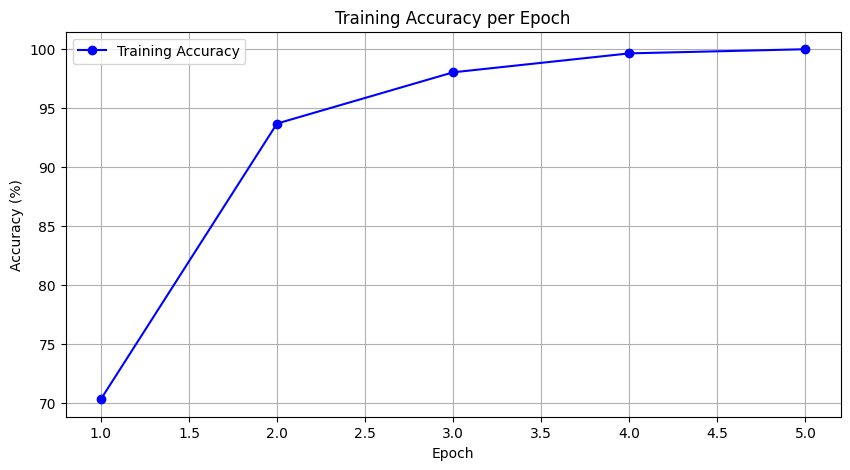

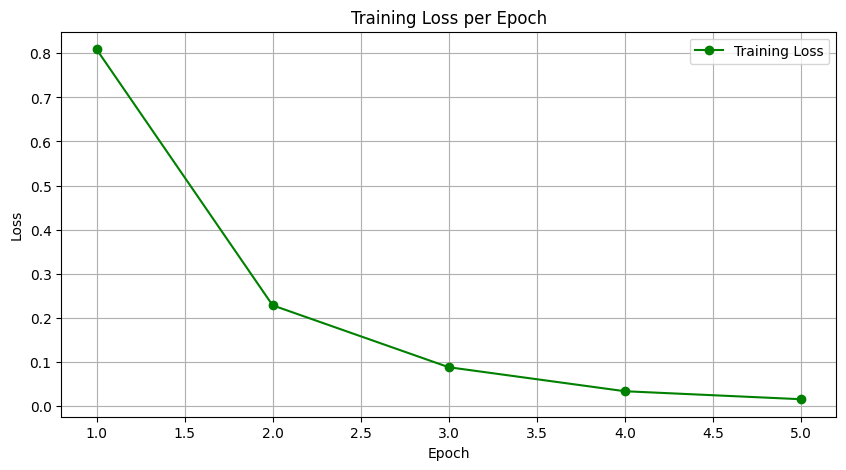

Test Loss: 0.2164, Test Accuracy: 93.30%


In [ ]:
import matplotlib.pyplot as plt

# Training loop without validation
epochs = 5
train_accuracies = []
train_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (input_ids, attention_mask, images, labels) in enumerate(train_loader):
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Training Loss {loss.item():.4f}")

    epoch_loss = total_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

print("Training complete.")

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='g', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Testing phase
model.eval()
test_correct = 0
test_total = 0
test_loss_total = 0

with torch.no_grad():
    for test_input_ids, test_attention_mask, test_images, test_labels in test_loader:
        test_input_ids, test_attention_mask = test_input_ids.to(device), test_attention_mask.to(device)
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_input_ids, test_attention_mask, test_images)
        test_loss = criterion(test_outputs, test_labels)
        test_loss_total += test_loss.item()

        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_loss_avg = test_loss_total / len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')


In [ ]:
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for test_input_ids, test_attention_mask, test_images, test_labels in test_loader:
        test_input_ids, test_attention_mask = test_input_ids.to(device), test_attention_mask.to(device)
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_input_ids, test_attention_mask, test_images)
        _, test_predicted = torch.max(test_outputs, 1)

        all_true_labels.extend(test_labels.cpu().numpy())
        all_predicted_labels.extend(test_predicted.cpu().numpy())


In [ ]:
class_names = [
    "2016 World Series",
    "2014 FIFA World Cup",
    "2014 Hong Kong protests",
    "2015 Baltimore protests",
    "2018 FIFA World Cup"
]


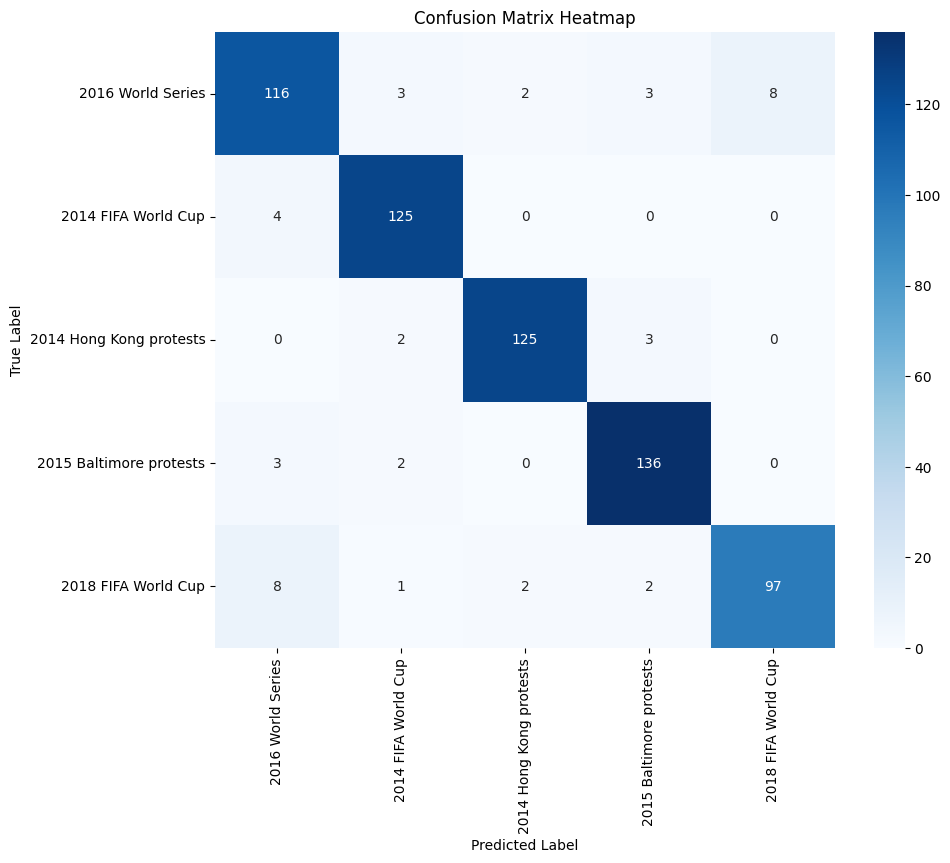

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
model = MultimodalModel(num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Batch 0: Training Loss 1.5831
Batch 100: Training Loss 0.8016
Epoch 1, Training Loss: 0.7909, Training Accuracy: 71.18%
Batch 0: Training Loss 0.2405
Batch 100: Training Loss 0.1488
Epoch 2, Training Loss: 0.2302, Training Accuracy: 93.54%
Batch 0: Training Loss 0.0352
Batch 100: Training Loss 0.0210
Epoch 3, Training Loss: 0.0975, Training Accuracy: 97.81%
Training complete.


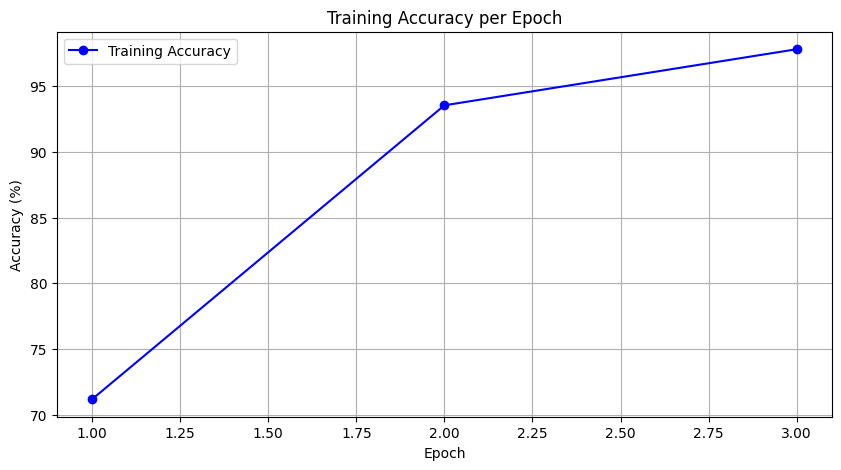

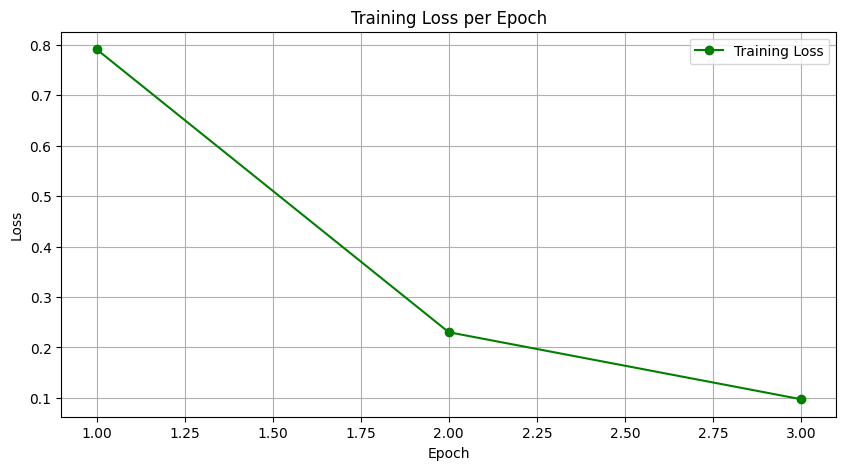

Test Loss: 0.2341, Test Accuracy: 92.52%


In [ ]:
import matplotlib.pyplot as plt

# Training loop without validation
epochs = 3
train_accuracies = []
train_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (input_ids, attention_mask, images, labels) in enumerate(train_loader):
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Training Loss {loss.item():.4f}")

    epoch_loss = total_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

print("Training complete.")

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='g', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Testing phase
model.eval()
test_correct = 0
test_total = 0
test_loss_total = 0

with torch.no_grad():
    for test_input_ids, test_attention_mask, test_images, test_labels in test_loader:
        test_input_ids, test_attention_mask = test_input_ids.to(device), test_attention_mask.to(device)
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_input_ids, test_attention_mask, test_images)
        test_loss = criterion(test_outputs, test_labels)
        test_loss_total += test_loss.item()

        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_loss_avg = test_loss_total / len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')


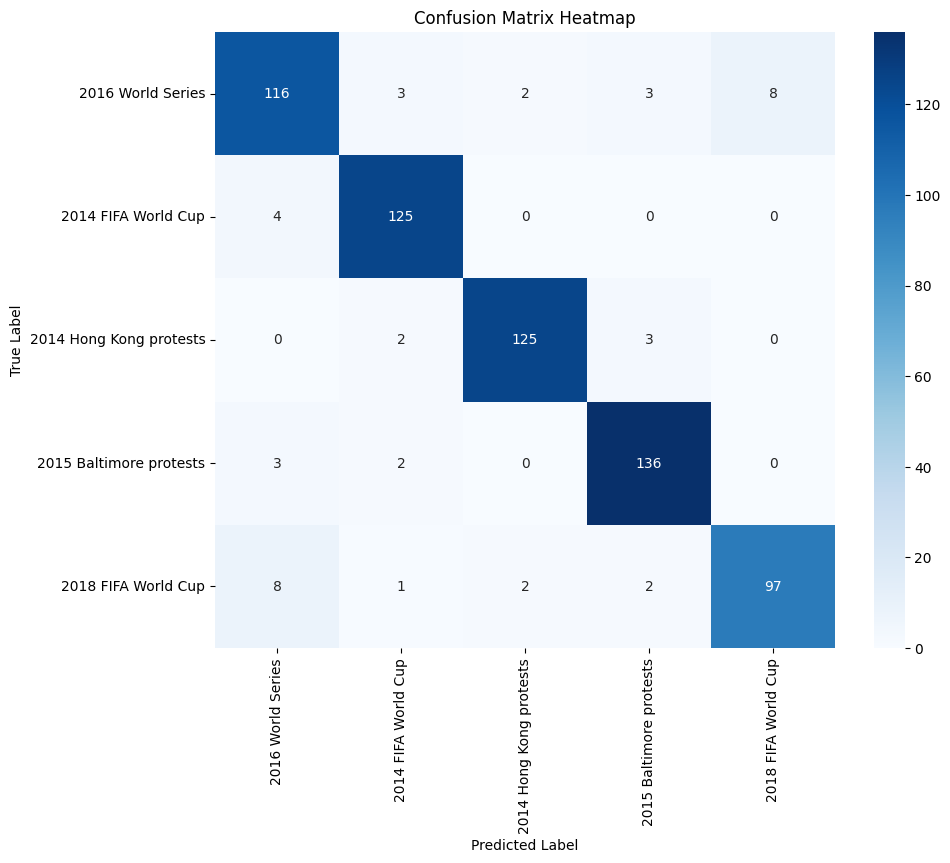

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
macro_f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
print(f'Macro F1 Score: {macro_f1:.4f}')

Macro F1 Score: 0.9317


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchvision import models

class MultimodalModel(nn.Module):
    def __init__(self, num_classes=5):
        super(MultimodalModel, self).__init__()
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.image_encoder = models.mobilenet_v2(pretrained=True)
        self.image_encoder.classifier = nn.Sequential(*list(self.image_encoder.classifier.children())[:-1])
        self.fc = nn.Linear(768 + 1280, num_classes)

    def forward(self, input_ids, attention_mask, images):
        text_emb = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        image_emb = self.image_encoder(images)
        combined_emb = torch.cat((text_emb, image_emb), dim=1)
        output = self.fc(combined_emb)
        return output


In [ ]:
model = MultimodalModel(num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s]


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchvision import models

class MultimodalModel(nn.Module):
    def __init__(self, num_classes=5, vocab_size=30522):  # Default vocab size for BERT
        super(MultimodalModel, self).__init__()
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.image_encoder = models.resnet50(pretrained=True)
        self.image_encoder.fc = nn.Sequential(*list(self.image_encoder.fc.children())[:-1])  # Remove the classification head
        self.fc = nn.Linear(768 + 2048, num_classes)  # 2048 is the output size of ResNet50

    def forward(self, input_ids, attention_mask, images):
        text_emb = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        image_emb = self.image_encoder(images)
        combined_emb = torch.cat((text_emb, image_emb), dim=1)
        output = self.fc(combined_emb)
        return output


In [ ]:
model = MultimodalModel(num_classes=5, vocab_size=30522).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Batch 0: Training Loss 1.6268
Batch 100: Training Loss 0.6424
Epoch 1, Training Loss: 0.6995, Training Accuracy: 75.45%
Batch 0: Training Loss 0.0781
Batch 100: Training Loss 0.1776
Epoch 2, Training Loss: 0.1964, Training Accuracy: 94.40%
Batch 0: Training Loss 0.0316
Batch 100: Training Loss 0.0498
Epoch 3, Training Loss: 0.0712, Training Accuracy: 98.59%
Batch 0: Training Loss 0.0292
Batch 100: Training Loss 0.0234
Epoch 4, Training Loss: 0.0280, Training Accuracy: 99.57%
Batch 0: Training Loss 0.0085
Batch 100: Training Loss 0.0059
Epoch 5, Training Loss: 0.0155, Training Accuracy: 99.84%
Training complete.


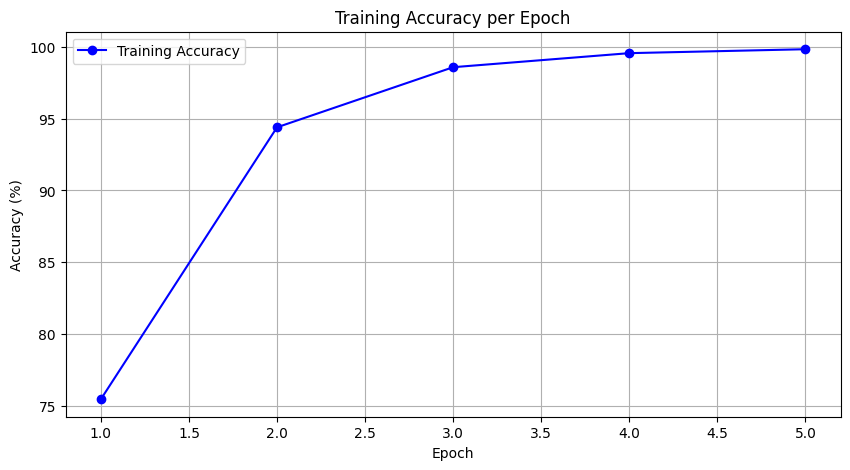

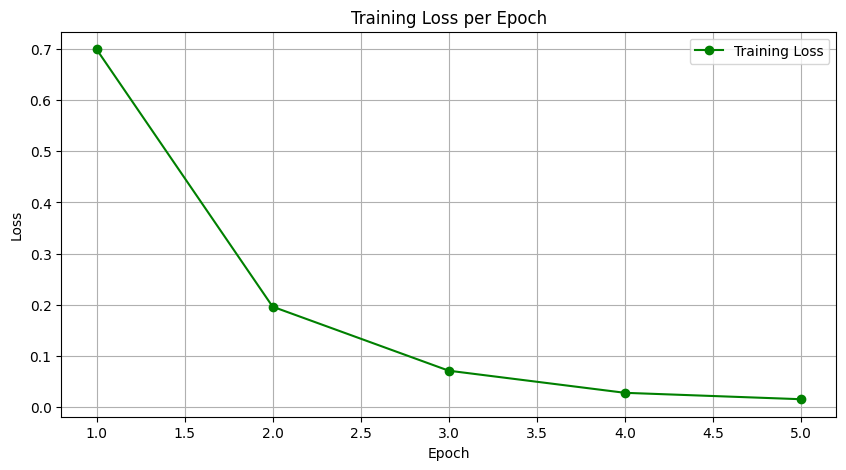

In [ ]:
import matplotlib.pyplot as plt

# Training loop without validation
epochs = 5
train_accuracies = []
train_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (input_ids, attention_mask, images, labels) in enumerate(train_loader):
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Training Loss {loss.item():.4f}")

    epoch_loss = total_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

print("Training complete.")

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='g', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Testing phase
model.eval()
test_correct = 0
test_total = 0
test_loss_total = 0

with torch.no_grad():
    for test_input_ids, test_attention_mask, test_images, test_labels in test_loader:
        test_input_ids, test_attention_mask = test_input_ids.to(device), test_attention_mask.to(device)
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_input_ids, test_attention_mask, test_images)
        test_loss = criterion(test_outputs, test_labels)
        test_loss_total += test_loss.item()

        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_loss_avg = test_loss_total / len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from torchvision import models, transforms
from torch.utils.data import Dataset
from PIL import Image

class MultimodalModel(nn.Module):
    def __init__(self, bert_model, squeezenet_model, num_classes):
        super(MultimodalModel, self).__init__()
        self.bert_model = bert_model
        self.squeezenet_model = squeezenet_model
        self.fc1 = nn.Linear(768 + 512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, images):
        text_features = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        image_features = self.squeezenet_model(images).view(images.size(0), -1)

        combined_features = torch.cat((text_features, image_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class MultiModalDataset(Dataset):
    def __init__(self, data, transform, max_length=512):
        self.data = data
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['cleaned_text']
        image_path = "./images/" + self.data.iloc[idx]['Image_filename']
        label = self.data.iloc[idx]['label']

        inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        input_ids = inputs['input_ids'].squeeze(0).to(device)
        attention_mask = inputs['attention_mask'].squeeze(0).to(device)

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image).to(device)

        return input_ids, attention_mask, image, torch.tensor(label, device=device)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

squeezenet_model = models.squeezenet1_1(pretrained=True).to(device)
squeezenet_model.classifier = nn.AdaptiveAvgPool2d(1)

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = MultiModalDataset(data, transform=image_transform)


In [ ]:
num_classes = len(filtered_data_top_10['Event_name'].unique())
model = MultimodalModel(bert_model, squeezenet_model, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_ids, attention_mask, images, labels in train_loader:
            input_ids, attention_mask, images, labels = input_ids.to(device), attention_mask.to(device), images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")
        torch.save(model.state_dict(), f'model_{epoch}.pth')
        torch.save(optimizer.state_dict(), f'optimizer_{epoch}.pth')

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, images, labels in test_loader:
            input_ids, attention_mask, images, labels = input_ids.to(device), attention_mask.to(device), images.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/5, Loss: 0.5155749523611827
Epoch 2/5, Loss: 0.1955098402523218
Epoch 3/5, Loss: 0.09674965466261694
Epoch 4/5, Loss: 0.0623699047615769
Epoch 5/5, Loss: 0.0559842852417545
Test Accuracy: 89.33%
